<h1 style="text-align: center;"> Classificação de artes utilizando CNN's </h1>

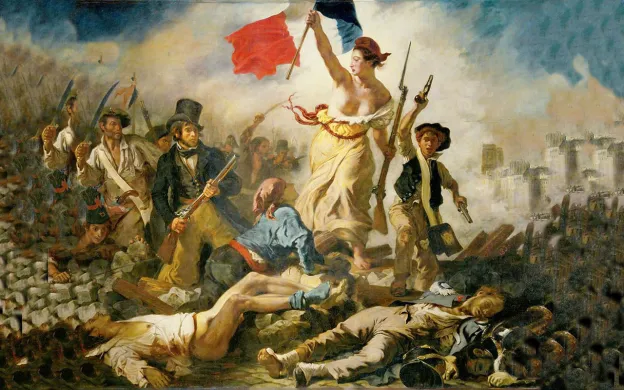
<br>
<div style="text-align: right"> <i>La Liberté guidant le peuple Eugène Delacroix</i> </div>
 

> "Jeová Deus disse então: “O homem se tornou como um de nós, sabendo o que é bom e o que é mau. Agora, para que ele não estenda a mão e pegue também do fruto da árvore da vida, e coma, e viva para sempre, . . .”" 

*~Gênesis 3:22*

## Talvez a arte esteja mudando

A arte está em constante mudança, seria a máquina o próximo passo para a arte humana ?
Um pouco contraditório né ... Quem sou para dizer o que é arte ?

Talvez meu conhecimento como programador não me permita pensar além do que isso significa, portanto através deste artigo você verá a classificação dos tipos de arte (moderna ou clássica) de acordo com uma rede neural.

### Instalando dependências

Vamos começar instalando as dependências necessárias utilizando o gerenciador de pacotes pip, note que comandos iniciados com ! siginifica códigos executados no terminal.

In [1]:
!pip install -Uqq fastai duckduckgo_search

Instalada as dependências necessárias faremos a importação e a criação de função para a busca das imagens utilizando o DuckDuckGo images:

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### Baixando as imagens a serem classificadas

Vamos começar com o DuckDuckGo para procurar uma imagem de arte clássica.

In [3]:
urls = search_images('classical art', max_images=1)
urls[0]

Searching for 'classical art'


'https://wallpaperaccess.com/full/3342724.jpg'

Tendo achado a imagem, vamos baixá-la.

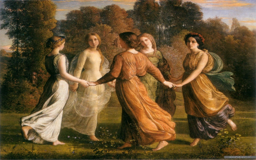

In [4]:
from fastdownload import download_url
dest = 'classicalart.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Agora vamos procurar uma imagem de arte moderna

Searching for 'modern art'


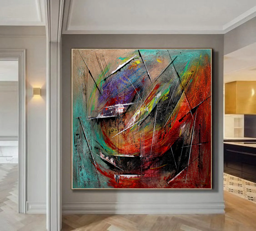

In [5]:
download_url(search_images('modern art', max_images=1)[0], 'modernart.jpg', show_progress=False)
Image.open('modernart.jpg').to_thumb(256,256)

Interessante não ?!

Agora vamos utilizar os diferentes tipos de imagens para cada pasta diferente para que possamos utilizar no nosso modelo de classificação posteriormente.

In [6]:
searches = 'classical art','modern art'
path = Path('classical_or_modern')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} paint'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sculptures'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)
    

Searching for 'classical art paint'
Searching for 'classical art sculptures'
Searching for 'modern art paint'
Searching for 'modern art sculptures'


Baixaremos aqui, pinturas e esculturas de arte clássica e moderna diferentes para utilizar como dados em nosso modelo.

Observe que fizemos o redimensionamento do tamanho máximo de 400px nas imagens, pois as GPU's são realmente boas com imagens grandes, porém a maior demora é para abrir as imagens.

Algumas imagens podem não ser baixadas corretamente, portanto vamos removê-las para que o nosso modelo não seja prejudicado.

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

### Treinando nosso modelo

Uma grande dificuldade que percebi ao treinar modelos de inteligência artificial é em manipular os dados que serão utilizados durante o processo de aprendizagem.

Para um *training set* (dados utilizados para o treinamento da rede) precisaremos de `DataLoaders`, com o `FastAi` utilizamos facilmente a função `DataBlock` que é uma forma de modificar esses dados inclusive randomizando uma parcela destes dados para um *validation set* (medem a acurácia do modelo).

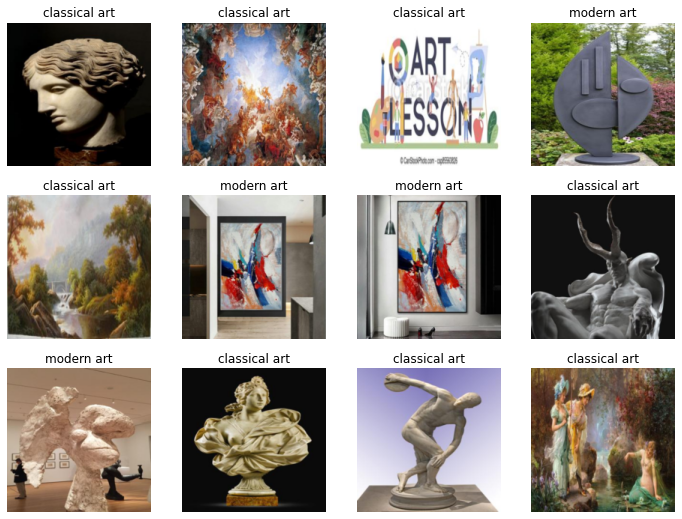

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

Aqui o que cada parâmetro do `DataBlock` significa:

    blocks=(ImageBlock, CategoryBlock),

Os dados de entrada do nosso modelo são imagens, e as saídas são categorias (neste caso, "arte clássica" ou "arte moderna").

    get_items=get_image_files, 

Para achar todas as imagens utilizadas, rodaremos a função `get_image_files` essa função retorna uma lista de todas as imagens do diretório.

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Randomicamente seta uma quantidade para utilizar no modelo de validação e no modelo de treinamento, neste caso utiliza 0.2 (20%) para o validar o modelo.

    get_y=parent_label,

Rotulação do dado de acordo com o diretório "pai", isso é, divide o rótulo das imagens entre imagens clássicas e modernas.

    item_tfms=[Resize(192, method='squish')]

Antes do treinamento, redimensiona cada imagem para 192x192 pixels "expremendo" as (O oposto de cortá-las).

### Treinando o modelo

Agora com os dados devidamente manipulados vamos realizar o treinamento.

Para treinar nós utilizaremos um modelo de visão computacional bastante utilizado que é o `resnet18`, este modelo pode ser treinado em pouco tempo utilizando até mesmo a CPU, e utilizando a GPU demora poucos segundos. 

Além disso esse a `fastai`conta com um método `fine_tune()` que é um modelo pré-treinado que contém pesos que já passaram por treinamento de diversas imagens (cerca de 1 milhão), isso diminui muito consideravelmente o tempo de treinamento do modelo.

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\Users\Mateus\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mateus\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.690911,0.274967,0.061538,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.194518,0.150869,0.030769,00:23
1,0.109927,0.160782,0.023077,00:22
2,0.071681,0.141048,0.015385,00:22


### Testando o modelo

Agora com o modelo treinado vamos ver se ele é eficiente em diferenciar arte clássica e moderna.

Utilizaremos a primeiramente a arte de DuChamp para ver o que nosso modelo vai caracterizar.

Searching for 'duchamp art'


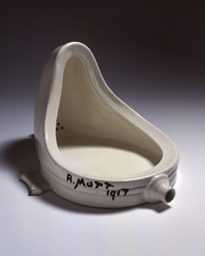

In [10]:
imgTest = search_images('duchamp art', max_images=1)
imgTest[0]
destino = 'duchampart.jpg'
download_url(imgTest[0], destino, show_progress=False)
im = Image.open(destino)
im.to_thumb(256,256)

In [11]:
imgTest = search_images

which_art,_,probs = learn.predict(PILImage.create('duchampart.jpg'))
print(f"This is a: {which_art}.")
print(f"Probabilidade de ser arte clássica: {probs[0]:.4f}")

This is a: modern art.
Probabilidade de ser arte clássica: 0.0740


Como podemos ver, nosso modelo caracterizou a arte sendo como moderna tendo uma probabilidade de apenas 2% de ser considerada clássica, o que é bem pouco e está correto.

Agora vamos testar um clássico da arte, a Mona Lisa de Leonardo da Vinci

Searching for 'Mona Lisa'


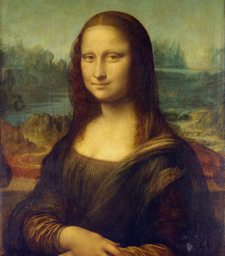

In [12]:
imgTest = search_images('Mona Lisa', max_images=1)
imgTest[0]
destino = 'monalisa.jpg'
download_url(imgTest[0], destino, show_progress=False)
im = Image.open(destino)
im.to_thumb(256,256)

In [13]:
imgTest = search_images

which_art,_,probs = learn.predict(PILImage.create('monalisa.jpg'))
print(f"This is a: {which_art}.")
print(f"Probabilidade de ser arte clássica: {probs[0]:.4f}")

This is a: classical art.
Probabilidade de ser arte clássica: 0.9998


Como podemos ver o modelo caracterizou corretamente em arte clássica, tendo uma probabilidade de acurácia de 96%.

### Resultado

Como podemos ver o modelo apresentou uma boa acurácia e um tempo pequeno para o treinamento, em minha máquina com GPU demorou cerca de 30 segundos. O que realmente é bem interessante já que em pouco tempo, com poucas linhas de código é possível fazer um modelo que consegue distinguir corretamente e definir se uma arte é clássica ou moderna.

Sendo assim como programadores podemos ficar mais tranquilos e nos preocupar mais em programação do que em classificação de arte.